In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

In [3]:
!pip install keras-unet

In [4]:
import keras
from keras_unet.models import custom_unet

2023-03-07 13:33:31.813599: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/kunal.jain001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [5]:
DATAPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/npy_files'
images_file = os.path.join(DATAPATH, 'fly-mar-06-original-images.npy')
labels_file = os.path.join(DATAPATH, 'fly-mar-06-segmented.npy')

In [6]:
images = np.load(images_file)
labels = np.load(labels_file)

In [7]:
images.shape

(56, 512, 512)

In [8]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [9]:
images.shape

(56, 512, 512, 1)

In [10]:
labels.shape

(56, 512, 512, 1)

In [11]:
p = np.random.permutation(len(images))

In [12]:
p

array([24, 42, 50, 53, 19, 40, 35,  2,  1, 28, 29, 55,  4, 13, 22, 21,  0,
       43, 33, 47, 30, 49, 16, 38, 26,  5, 54, 10, 27, 12,  9, 37, 25, 17,
       11, 34, 31, 23, 41, 14, 44, 32, 48, 18, 20, 39,  3, 46, 45, 36,  7,
       52,  8,  6, 15, 51])

In [13]:
images = images[p]
labels = labels[p]

In [14]:
labels = labels.astype(np.float64)

In [15]:
import tensorflow as tf

In [16]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    mask = labels[i]
    image = images[i]

    # Flip the image horizontally
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Flip the image vertically
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Rotate the image 90 degrees
    if tf.random.uniform(()) > 0.5:
        #
        # TODO: YOUR CODE
        #
        image = tf.image.rot90(image)
        mask = tf.image.rot90(mask)


    # augmentation done, let's store the image
    images[i] = image
    labels[i] = mask


2023-03-07 13:33:34.594416: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-07 13:33:34.623746: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-07 13:33:34.623767: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: chimera13
2023-03-07 13:33:34.623772: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: chimera13
2023-03-07 13:33:34.623832: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.172.1
2023-03-07 13:33:34.623847: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 450.172.1
2023-03-07 13:33:34.623851: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 450.172.1
2023-03-07 13:33:34.624383: I tensorflow/core/platform/cpu_fe

In [17]:
images.shape

(56, 512, 512, 1)

In [18]:
labels.shape

(56, 512, 512, 1)

In [19]:
X_train = images[0:40]
y_train = labels[0:40]
X_val = images[40:50]
y_val = labels[40:50]
X_test = images[50:]
y_test = labels[50:]

In [20]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=32,
    dropout=0.5,
    output_activation='sigmoid')

In [21]:
import keras.optimizers
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

In [22]:
opt = keras.optimizer_v1.Adam(lr=0.01)

In [23]:
model.compile(optimizer = 'Adam',    
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [24]:
history = model.fit(X_train, 
                    y_train, 
                    32, 
                    epochs=100,
                    validation_data=(X_val, y_val), 
                    verbose=1)

2023-03-07 13:33:35.713603: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-07 13:33:35.733225: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/100
2/2 [==============================] - 229s 57s/step - loss: 0.7867 - iou: 0.1007 - iou_thresholded: 0.0793 - val_loss: 1.0107 - val_iou: 0.0025 - val_iou_thresholded: 5.4180e-04
Epoch 2/100
2/2 [==============================] - 227s 56s/step - loss: 2.1558 - iou: 0.0319 - iou_thresholded: 4.0365e-04 - val_loss: 0.5615 - val_iou: 0.0807 - val_iou_thresholded: 0.0011
Epoch 3/100
2/2 [==============================] - 227s 56s/step - loss: 0.5294 - iou: 0.0819 - iou_thresholded: 0.0081 - val_loss: 0.5698 - val_iou: 0.0815 - val_iou_thresholded: 7.9419e-04
Epoch 4/100
2/2 [==============================] - 226s 56s/step - loss: 0.5319 - iou: 0.0805 - iou_thresholded: 4.9144e-04 - val_loss: 0.5510 - val_iou: 0.0792 - val_iou_thresholded: 1.5138e-04
Epoch 5/100
2/2 [==============================] - 227s 56s/step - loss: 0.5211 - iou: 0.0752 - iou_thresholded: 3.2134e-04 - val_loss: 0.5186 - val_iou: 0.0747 - val_iou_thresholded: 3.7011e-06
Epoch 6/100
2/2 [====================

Epoch 43/100
2/2 [==============================] - 227s 57s/step - loss: 0.3443 - iou: 0.0661 - iou_thresholded: 2.8898e-06 - val_loss: 0.3115 - val_iou: 0.1037 - val_iou_thresholded: 3.7020e-06
Epoch 44/100
2/2 [==============================] - 227s 56s/step - loss: 0.3340 - iou: 0.0815 - iou_thresholded: 2.5438e-06 - val_loss: 0.3024 - val_iou: 0.1093 - val_iou_thresholded: 3.7020e-06
Epoch 45/100
2/2 [==============================] - 227s 56s/step - loss: 0.3293 - iou: 0.0856 - iou_thresholded: 2.8061e-06 - val_loss: 0.2878 - val_iou: 0.1152 - val_iou_thresholded: 3.7020e-06
Epoch 46/100
2/2 [==============================] - 227s 56s/step - loss: 0.3184 - iou: 0.0883 - iou_thresholded: 2.6274e-06 - val_loss: 0.2651 - val_iou: 0.1224 - val_iou_thresholded: 3.7020e-06
Epoch 47/100
2/2 [==============================] - 227s 56s/step - loss: 0.3291 - iou: 0.0828 - iou_thresholded: 2.9372e-06 - val_loss: 0.2645 - val_iou: 0.1274 - val_iou_thresholded: 3.7020e-06
Epoch 48/100
2/2 [==

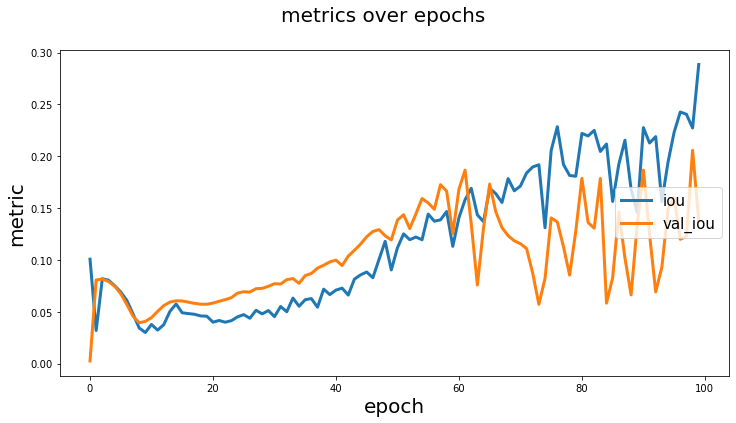

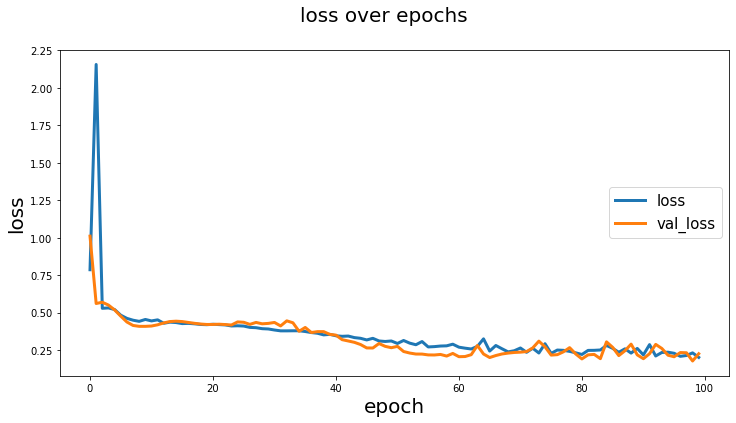

In [25]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [50]:
y_pred = model.predict(X_test)

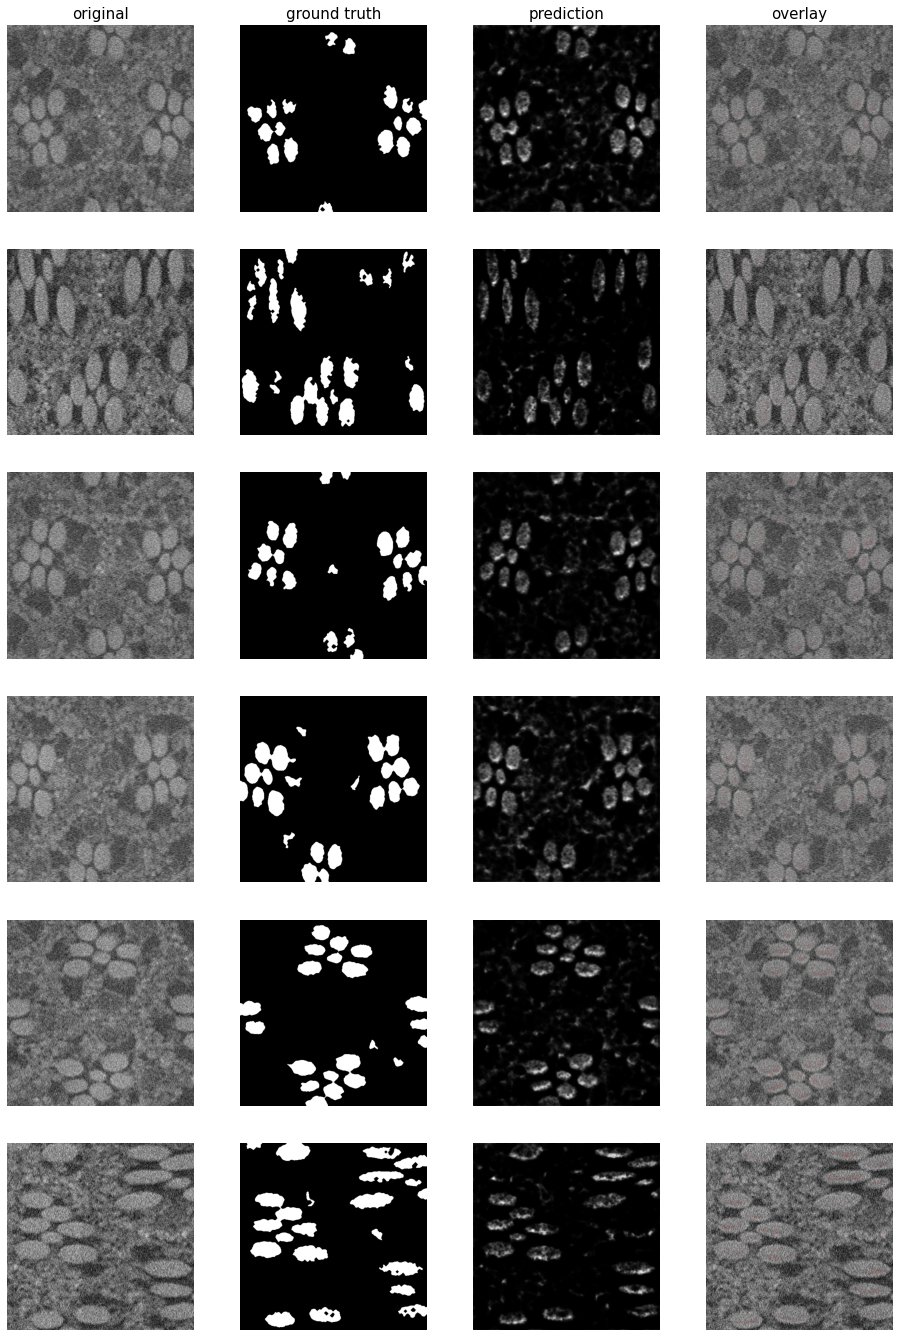

In [51]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

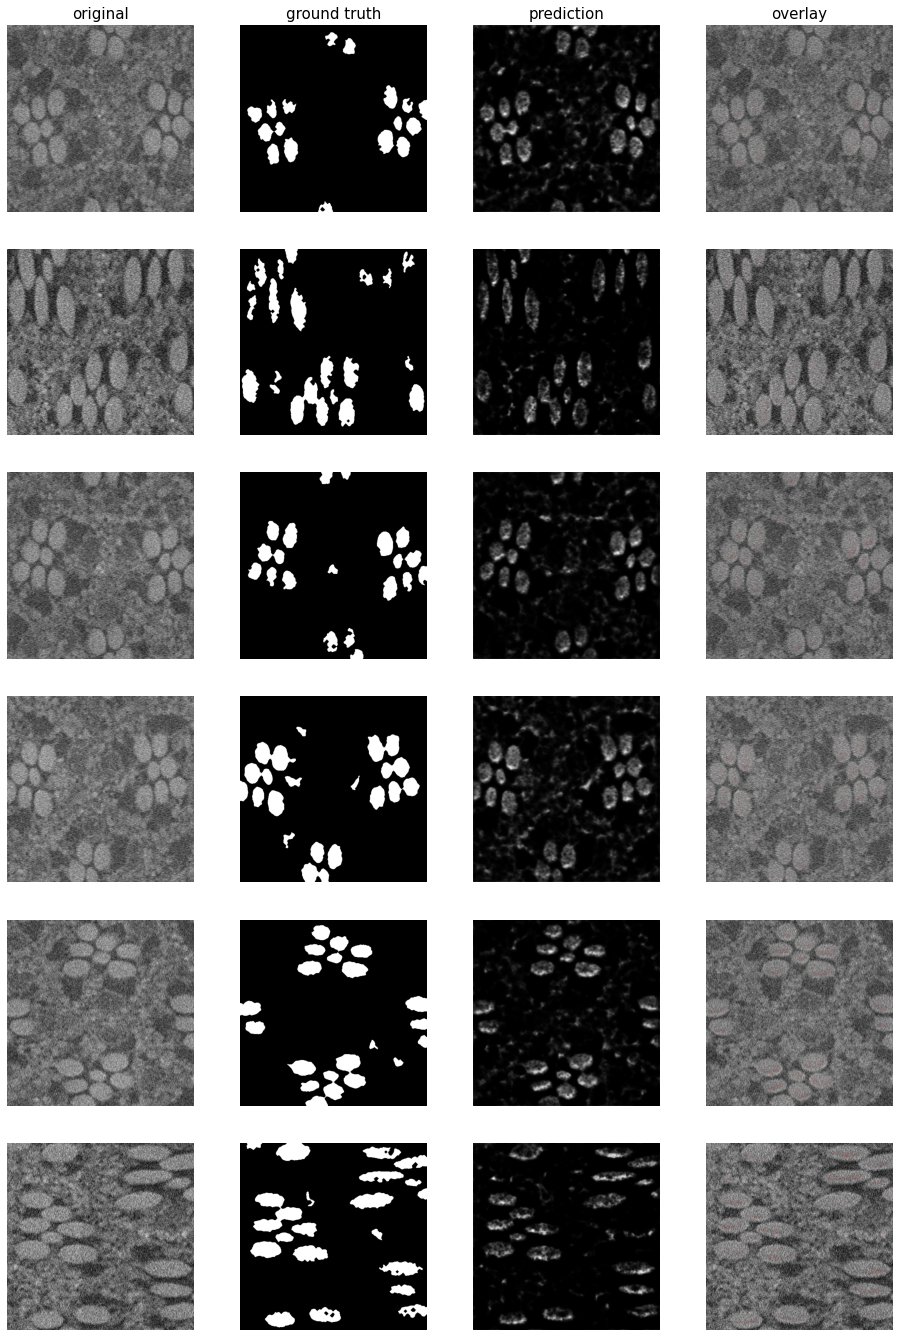

In [33]:
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

In [52]:
y_pred.shape

(6, 512, 512, 1)

In [53]:
X_test.shape

(6, 512, 512, 1)

In [54]:
DATAPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/03-07-test'

In [55]:
from PIL import *
# Get a list of file names in the directory
file_names = os.listdir(DATAPATH)
print(file_names)

# Create an empty list to store the NumPy arrays
image_arrays = []

# Loop over each file name and open the image, convert to a NumPy array, and append to the list
for fname in file_names:
    image = Image.open(os.path.join(DATAPATH, fname))
    array = np.array(image)[1500:2012, 2968:3480]
    image_arrays.append(array)

# Convert the list of NumPy arrays to a NumPy array
image_array = np.array(image_arrays)

['000000_000000_000432_000000.tif', '000000_000000_000431_000000.tif', '000000_000000_000428_000000.tif', '000000_000000_000433_000000.tif', '000000_000000_000429_000000.tif', '000000_000000_000434_000000.tif']


In [56]:
image_array.shape

(6, 512, 512)

In [63]:
X_test_new = np.expand_dims(image_array, axis=3)

In [66]:
X_test_new.shape

(6, 512, 512, 1)

In [67]:
y_pred_new = model.predict(X_test_new)

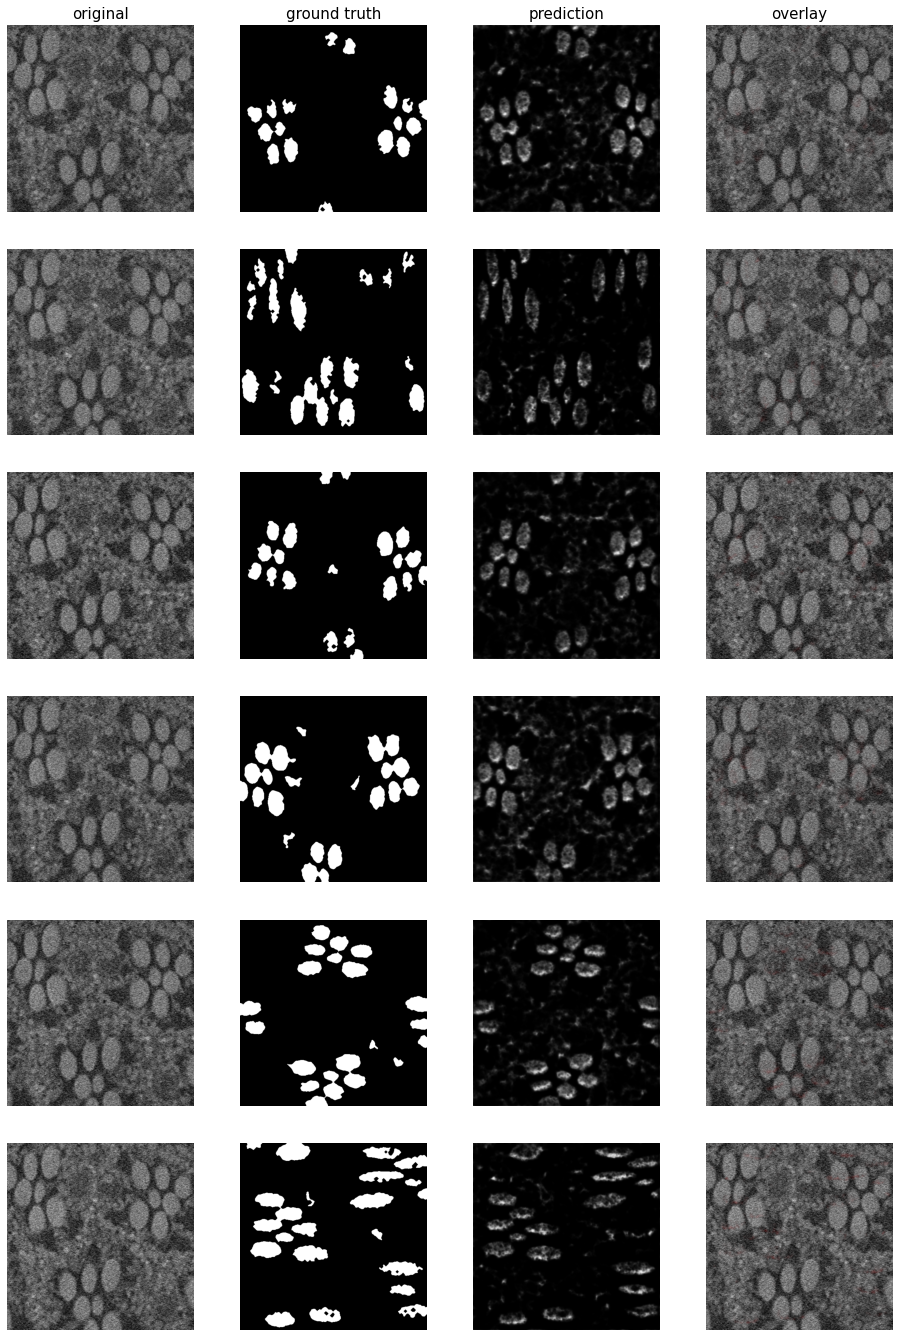

In [69]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test_new, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)